
# DCGAN — Anime Face Generator (128×128)
**Notebook**: Ready-to-run DCGAN implementation using PyTorch.  
**Dataset**: Anime Face Dataset (63k images, 128×128).  
**Instructions**: Place all training images (jpg/png) inside `./data/anime_faces/` (no nested folders) before running.  
This notebook will use GPU if available (CUDA).

**What this notebook includes**
- Environment setup (install packages if needed)
- Dataset loading & preprocessing
- DCGAN Generator & Discriminator implementations
- Training loop with checkpointing and periodic sample generation
- Utilities to load checkpoints and generate final images

> Recommended runtime: GPU (NVIDIA). For quick experiments use Google Colab with a GPU runtime.


In [2]:

# If you're running on a fresh environment, uncomment and run the following to install required packages.
# On Colab, torchvision and torch are usually installed; adjust versions if necessary.

# !pip install torch torchvision matplotlib tqdm pillow numpy

# Verify GPU availability
import torch
print('PyTorch version:', torch.__version__)
print('CUDA available:', torch.cuda.is_available())
print('Device count:', torch.cuda.device_count())
if torch.cuda.is_available():
    print('Current device:', torch.cuda.get_device_name(0))


PyTorch version: 2.9.1+cu128
CUDA available: True
Device count: 1
Current device: NVIDIA GeForce RTX 4070 Ti SUPER


In [3]:

import os
import random
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


Found 63565 images in data/anime_faces
Batch shape: torch.Size([8, 3, 128, 128])


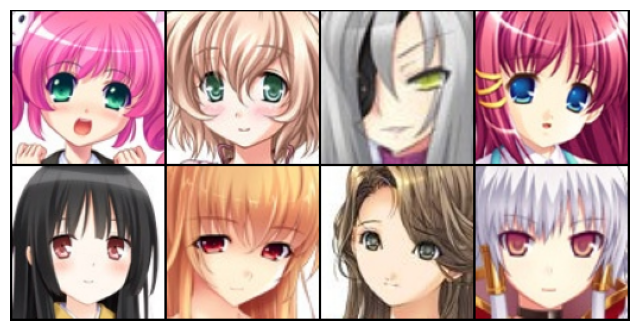

In [4]:

# Dataset: expects images in ./data/anime_faces/*.jpg or .png
from pathlib import Path

data_dir = Path('data/anime_faces')
image_paths = sorted([str(p) for p in data_dir.glob('*') if p.suffix.lower() in ['.jpg', '.jpeg', '.png']])

print(f'Found {len(image_paths)} images in', data_dir)
assert len(image_paths) > 0, "No images found. Please download the dataset and put images in ./data/anime_faces/"

# Define PyTorch Dataset
class ImageFolderDataset(Dataset):
    def __init__(self, file_list, image_size=128, transforms_=None):
        self.file_list = file_list
        self.image_size = image_size
        if transforms_ is None:
            self.transforms = transforms.Compose([
                transforms.Resize((image_size, image_size)),
                transforms.CenterCrop(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),                 # 0..1
                transforms.Normalize([0.5]*3, [0.5]*3) # -1..1
            ])
        else:
            self.transforms = transforms_

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        path = self.file_list[idx]
        img = Image.open(path).convert('RGB')
        return self.transforms(img)

# Quick sanity check: show a few images
ds = ImageFolderDataset(image_paths, image_size=128)
loader = DataLoader(ds, batch_size=8, shuffle=True, num_workers=2, pin_memory=True)

batch = next(iter(loader))
print('Batch shape:', batch.shape)  # (B, C, H, W)

# show grid
grid = utils.make_grid((batch[:8] * 0.5) + 0.5, nrow=4)
plt.figure(figsize=(8,6))
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis('off')
plt.show()


In [5]:

# DCGAN model definitions (PyTorch)
# Reference: Radford et al., DCGAN. Uses transposed conv for generator and conv for discriminator.

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Hyperparameters
image_size = 128
nz = 100           # latent vector size
ngf = 64           # generator feature map size
ndf = 64           # discriminator feature map size
nc = 3             # number of channels (RGB)

# Generator
class Generator(nn.Module):
    def __init__(self, nz=100, ngf=64, nc=3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf*16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*16),
            nn.ReLU(True),
            # state size: (ngf*16) x 4 x 4
            nn.ConvTranspose2d(ngf*16, ngf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # 8 x 8
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # 16 x 16
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            # 32 x 32
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 64 x 64
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # output: nc x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 64
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # 32 x 32
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # 16 x 16
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # 8 x 8
            nn.Conv2d(ndf*8, ndf*16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*16),
            nn.LeakyReLU(0.2, inplace=True),
            # 4 x 4
            nn.Conv2d(ndf*16, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# Create models and apply weights_init
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
netG = Generator(nz=nz, ngf=ngf, nc=nc).to(device)
netG.apply(weights_init)
netD = Discriminator(nc=nc, ndf=ndf).to(device)
netD.apply(weights_init)

print(netG)
print(netD)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [6]:

# Training hyperparams
batch_size = 64
lr = 0.0002
beta1 = 0.5
num_epochs = 50
sample_dir = Path('samples')
ckpt_dir = Path('checkpoints')
sample_dir.mkdir(parents=True, exist_ok=True)
ckpt_dir.mkdir(parents=True, exist_ok=True)

dataloader = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

real_label = 1.
fake_label = 0.


In [7]:

# Training loop
from itertools import count
G_losses = []
D_losses = []
iters = 0

print('Starting Training Loop...')
for epoch in range(1, num_epochs+1):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network
        ############################
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward real batch through D
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake image batch with G
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)

        # Classify all fake batch with D
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network
        ############################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\tD(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}')

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            grid = utils.make_grid((fake * 0.5) + 0.5, nrow=8)
            img_path = sample_dir / f'epoch{epoch:03d}_iter{iters:06d}.png'
            utils.save_image((fake * 0.5) + 0.5, str(img_path), nrow=8)
        iters += 1

    # Save checkpoint each epoch
    torch.save({
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict()
    }, ckpt_dir / f'dcgan_epoch_{epoch:03d}.pth')
    print(f'Checkpoint saved: {ckpt_dir / f"dcgan_epoch_{epoch:03d}.pth"}')


Starting Training Loop...
[1/50][0/994]	Loss_D: 2.3816	Loss_G: 20.7283	D(x): 0.8052	D(G(z)): 0.7676/0.0000
[1/50][100/994]	Loss_D: 0.0000	Loss_G: 62.6378	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][200/994]	Loss_D: 0.0000	Loss_G: 62.1794	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][300/994]	Loss_D: 0.0000	Loss_G: 62.3166	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][400/994]	Loss_D: 0.0000	Loss_G: 61.6267	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][500/994]	Loss_D: 0.0000	Loss_G: 60.0152	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][600/994]	Loss_D: 0.0000	Loss_G: 59.1611	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][700/994]	Loss_D: 0.0000	Loss_G: 59.7449	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][800/994]	Loss_D: 0.0000	Loss_G: 59.8734	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[1/50][900/994]	Loss_D: 0.0000	Loss_G: 59.8959	D(x): 1.0000	D(G(z)): 0.0000/0.0000
Checkpoint saved: checkpoints/dcgan_epoch_001.pth
[2/50][0/994]	Loss_D: 0.0000	Loss_G: 59.5833	D(x): 1.0000	D(G(z)): 0.0000/0.0000
[2/50][100/994]

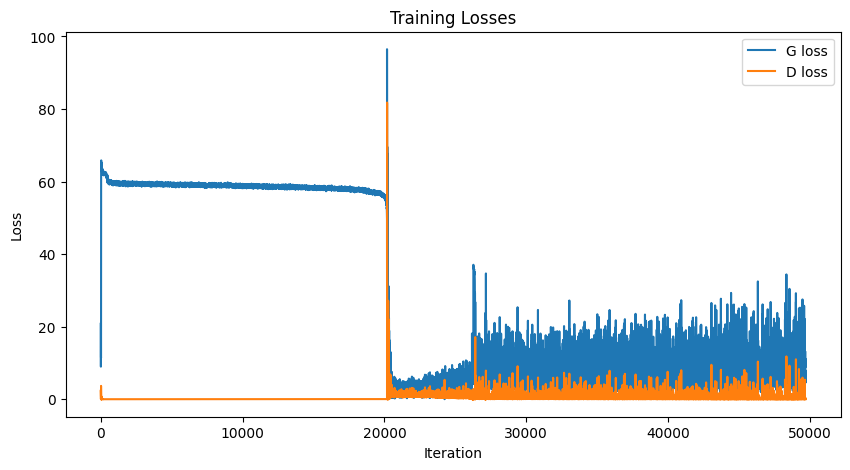

In [8]:

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(G_losses, label='G loss')
plt.plot(D_losses, label='D loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
plt.show()


Loading checkpoints/dcgan_epoch_050.pth


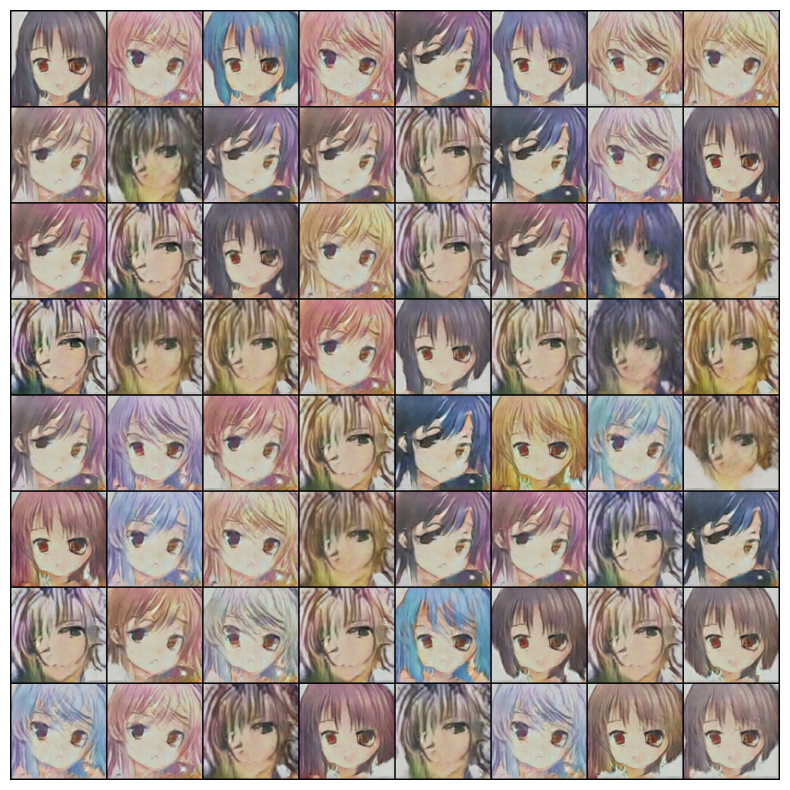

In [9]:

# Utility: load checkpoint and generate samples
def load_checkpoint(path, netG, netD, optG=None, optD=None, device='cpu'):
    ckpt = torch.load(path, map_location=device)
    netG.load_state_dict(ckpt['netG_state_dict'])
    netD.load_state_dict(ckpt['netD_state_dict'])
    if optG and optD:
        optG.load_state_dict(ckpt['optimizerG_state_dict'])
        optD.load_state_dict(ckpt['optimizerD_state_dict'])
    return ckpt.get('epoch', None)

# Generate and show samples from a checkpoint
sample_ckpt = sorted(ckpt_dir.glob('dcgan_epoch_*.pth'))[-1] if len(list(ckpt_dir.glob('dcgan_epoch_*.pth'))) > 0 else None
if sample_ckpt:
    print('Loading', sample_ckpt)
    load_checkpoint(sample_ckpt, netG, netD, optimizerG, optimizerD, device=device)
    with torch.no_grad():
        noise = torch.randn(64, nz, 1, 1, device=device)
        fake = netG(noise).detach().cpu()
    grid = utils.make_grid((fake * 0.5) + 0.5, nrow=8)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1,2,0).numpy())
    plt.axis('off')
    plt.show()
else:
    print('No checkpoint found yet. Train the model or place a checkpoint in the checkpoints/ directory.')


In [10]:

# Small inference helper: saves N generated images to out_dir
def generate_images(netG, n_images=64, out_dir=Path('generated'), batch_size=64):
    out_dir.mkdir(parents=True, exist_ok=True)
    netG.eval()
    with torch.no_grad():
        for i in range((n_images + batch_size - 1)//batch_size):
            cur = min(batch_size, n_images - i*batch_size)
            noise = torch.randn(cur, nz, 1, 1, device=device)
            fake = netG(noise).detach().cpu()
            for j in range(cur):
                img = ((fake[j] * 0.5) + 0.5).permute(1,2,0).numpy() * 255
                img = Image.fromarray(img.astype('uint8'))
                img.save(out_dir / f'img_{i*batch_size + j:04d}.png')
    print(f'Saved {n_images} images to', out_dir)

# Example usage (uncomment after training or loading checkpoint):
# generate_images(netG, n_images=64, out_dir=Path('generated_samples'))



---

## Next steps & tips

- **Dataset**: If you don't yet have the Anime Face dataset, download and extract it into `./data/anime_faces/`. Each image file should sit directly inside that folder. A popular dataset is the 'animeface' collection resized to 128×128. On Colab you can `!wget` a prepared zip, extract, and run this notebook.

- **Training time**: On a single NVIDIA T4 or GTX 1080, expect several hours for decent results at 128×128 for 50 epochs. You can reduce `num_epochs` for experimentation or increase it for better quality.

- **Experimentation**:
  - Try different `ngf/ndf` sizes (128 for larger models).
  - Use spectral normalization on Discriminator for stability.
  - Try hinge loss or Wasserstein GAN losses for better quality.
  - Use progressive growing for higher-resolution images (advanced).

- **Application**: After training, we can create a simple Streamlit app that loads a checkpoint and serves a `/generate` button to produce images. Streamlit is easiest for demos. If you want, I can now generate the Streamlit app code and a Dockerfile for serving the generator. Which app framework would you prefer? (I recommend **Streamlit** for demo ease.)

---
